<a href="https://colab.research.google.com/github/Erickpython/kodeCamp_5X-MachineLearning/blob/main/Copy_CIFAR_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task Objective

The CIFAR-10 dataset is a widely used benchmark dataset for image classification. It consists of 60,000 32×32 color images across 10 classes: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck
Unlike MNIST, which contains grayscale handwritten digits, CIFAR-10 is significantly more complex due to:

    RGB channels (3 instead of 1)
    Higher visual variability
    More difficult feature extraction

You are required to design and implement a Convolutional Neural Network (CNN) that can accurately classify images from the CIFAR-10 dataset. Ensure each step of the process is properly documented using a text block in your notebook just before the code block. Implement your solution in a Jupyter Notebook and submit the link below.


Requirements

    Load CIFAR-10 using PyTorch built-in datasets.
    Normalize the dataset properly.
    Perform an 80% – 20% train-validation split from the training data.
    Ensure data is shuffled before splitting.


CNN Architecture

    Your model must include at least 3 convolutional layers with each convolutional layer containing:
        A 2D Convolution
        Activation (ReLU)
        Pooling (MaxPooling recommended)
    Apply Dropout to improve generalization.
    Use fully connected layers after the convolution blocks.
    Final layer must use Softmax activation


Training Specifications

    Use either Adam or SGD optimizer.
    Select an appropriate learning rate.
    Use Cross Entropy Loss.
    Train for multiple epochs.


Regularization & Optimization

You must implement at least TWO of the following:

    Dropout
    Weight Decay (L2 Regularization)
    Data Augmentation (recommended — e.g., random flips, rotations)


Performance Target

Your model must achieve at least 70% validation accuracy.

Note: CIFAR-10 is harder than MNIST. Reaching this accuracy requires good architecture choices and training discipline.


Early Stopping

Implement early stopping to prevent unnecessary computation and reduce overfitting.

Clearly specify:

    Patience value
    Metric monitored


Visualization

Include the following plots:

    Training vs Validation Loss
    Training vs Validation Accuracy


Model Evaluation

At the end of training, print the following:

    Final Validation Accuracy
    Best Epoch
    Optimizer Used
    Learning Rate
    Regularization techniques applied



For extra marks, also display

    Confusion Matrix
    At least 5 correctly classified images
    At least 5 misclassified images

Explain possible reasons for the misclassifications.



NB: Ensure to grant comment access to all for your document to allow grading comments. You will get a zero score if you don't grant access to your document.

Use the attached notebooks as a template to guide you.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Data Augmentation & Normalization

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading Dataset

In [ ]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 80/20 Train-Validation Split
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
train_subset, val_subset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = DataLoader(val_subset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 77.2MB/s]


# 2. CNN Architecture

We implement three convolutional blocks. We use *Dropout* and *Weight Decay* (within the optimizer) as our two regularization techniques.

In [ ]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        # Block 1: 3 -> 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Block 2: 32 -> 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Block 3: 64 -> 128 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # FC Layers: After 3 pools, 32x32 becomes 4x4
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x) # Softmax applied in Loss or Final layer
        return x

# 3. Training Logic with Early Stopping

We will monitor Validation Loss. If it doesn't improve for 5 consecutive epochs (patience), we stop training to prevent overfitting.

    Optimizer: Adam

    Learning Rate: 0.001

    Weight Decay: 1e-4 (L2 Regularization)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Early Stopping parameters
patience = 5
min_val_loss = float('inf')
counter = 0

# 4. Training Loop with Early Stopping

We track both training and validation metrics per epoch. If the validation loss fails to improve for patience (5) epochs, we break the loop to save time and prevent overfitting.

In [ ]:
# Lists to store metrics for plotting
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

epochs = 50 # Maximum epochs;
best_epoch = 0

print("Starting Training...")
for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total

    # --- VALIDATION PHASE ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / len(valloader)
    val_acc = 100. * val_correct / val_total

    # Save metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%')

    # --- EARLY STOPPING LOGIC ---
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth') # Save the best version
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print(f"\nTraining Finished. Best Epoch: {best_epoch}")

Starting Training...
Epoch 1: Train Loss: 1.407 | Val Loss: 1.310 | Val Acc: 54.48%
Epoch 2: Train Loss: 1.051 | Val Loss: 0.920 | Val Acc: 67.56%
Epoch 3: Train Loss: 0.919 | Val Loss: 0.866 | Val Acc: 69.39%
Epoch 4: Train Loss: 0.841 | Val Loss: 0.904 | Val Acc: 68.33%
Epoch 5: Train Loss: 0.777 | Val Loss: 0.762 | Val Acc: 73.41%
Epoch 6: Train Loss: 0.736 | Val Loss: 0.856 | Val Acc: 70.29%
Epoch 7: Train Loss: 0.695 | Val Loss: 0.704 | Val Acc: 75.27%
Epoch 8: Train Loss: 0.661 | Val Loss: 0.662 | Val Acc: 76.96%
Epoch 9: Train Loss: 0.635 | Val Loss: 0.721 | Val Acc: 75.02%
Epoch 10: Train Loss: 0.610 | Val Loss: 0.659 | Val Acc: 76.95%
Epoch 11: Train Loss: 0.584 | Val Loss: 0.655 | Val Acc: 77.35%
Epoch 12: Train Loss: 0.566 | Val Loss: 0.619 | Val Acc: 78.59%
Epoch 13: Train Loss: 0.547 | Val Loss: 0.627 | Val Acc: 78.07%
Epoch 14: Train Loss: 0.537 | Val Loss: 0.613 | Val Acc: 79.27%
Epoch 15: Train Loss: 0.519 | Val Loss: 0.582 | Val Acc: 79.76%
Epoch 16: Train Loss: 0.506 

# 5. Visualization of Metrics


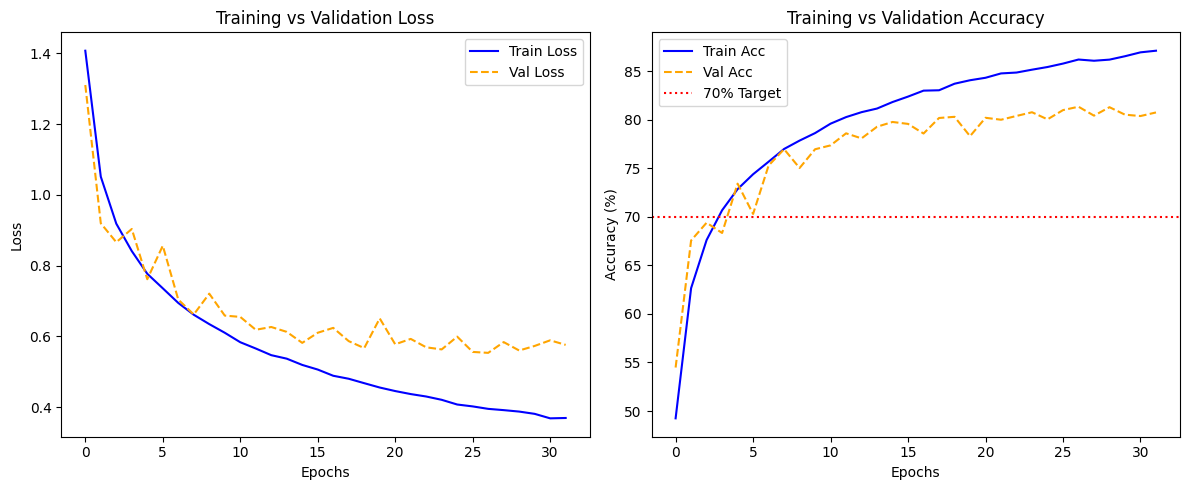

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='orange', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc', color='blue')
plt.plot(history['val_acc'], label='Val Acc', color='orange', linestyle='--')
plt.axhline(y=70, color='r', linestyle=':', label='70% Target')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Confusion Matrix and Final Evaluation

To analyze where the model "struggles," the confusion matrix shows which classes are being swapped.

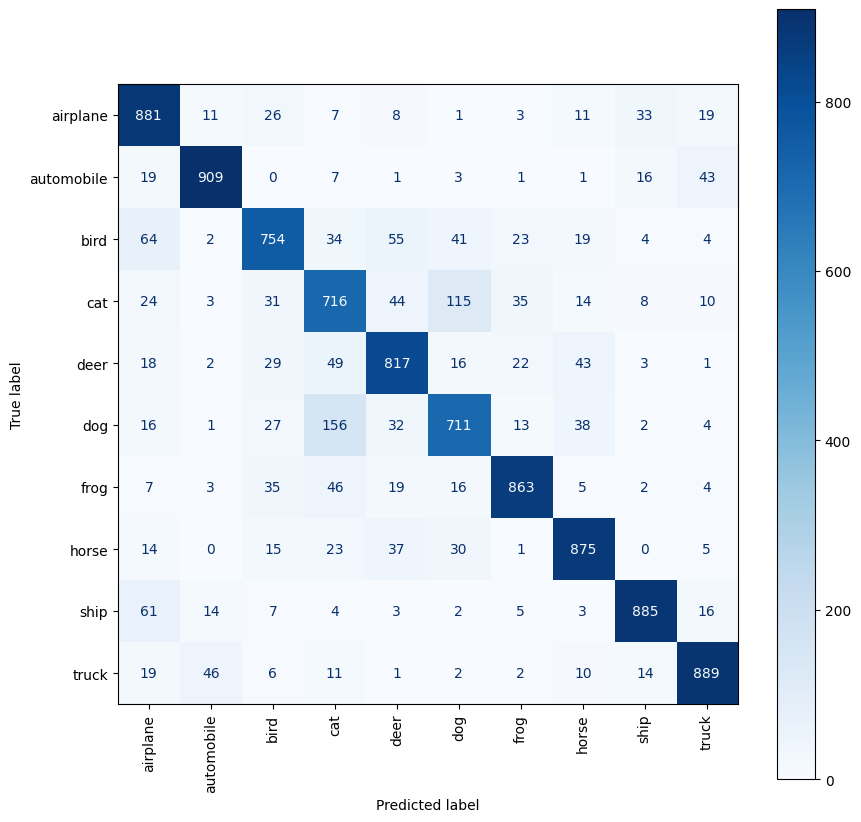

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.load_state_dict(torch.load('best_model.pth')) # Load best weights
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Display Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_trainset.classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(xticks_rotation='vertical', ax=ax, cmap='Blues')
plt.show()

# 7. Extract and Visualize Images

This script iterates through the test set to find 5 perfect matches and 5 "mistakes" made by the CNN.

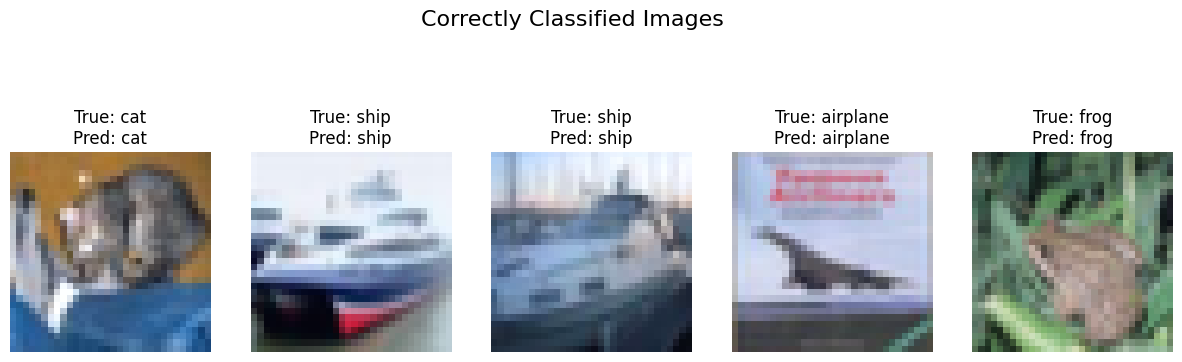

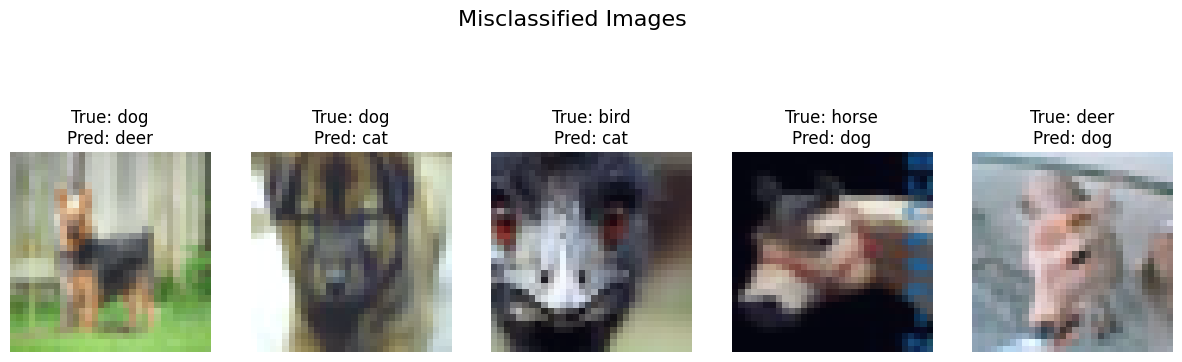

In [ ]:
# Inverse normalization for visualization (reverting Mean/STD)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = full_trainset.classes
correct_images, correct_labels, correct_preds = [], [], []
wrong_images, wrong_labels, wrong_preds = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Compare predictions to labels
        for i in range(len(labels)):
            if predicted[i] == labels[i] and len(correct_images) < 5:
                correct_images.append(images[i].cpu())
                correct_labels.append(labels[i].cpu())
                correct_preds.append(predicted[i].cpu())
            elif predicted[i] != labels[i] and len(wrong_images) < 5:
                wrong_images.append(images[i].cpu())
                wrong_labels.append(labels[i].cpu())
                wrong_preds.append(predicted[i].cpu())

        if len(correct_images) >= 5 and len(wrong_images) >= 5:
            break

# Plotting Function
def plot_images(imgs, labels, preds, title):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        # Denormalize for display
        img = imgs[i] * 0.2 + 0.5
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)).clip(0, 1))
        plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

plot_images(correct_images, correct_labels, correct_preds, "Correctly Classified Images")
plot_images(wrong_images, wrong_labels, wrong_preds, "Misclassified Images")